In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Jun  7 14:17:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.4 MB/s 
     |████████████████████████████████| 581 kB 65.7 MB/s 
     |████████████████████████████████| 965 kB 57.5 MB/s 
     |████████████████████████████████| 235 kB 61.6 MB/s 


In [4]:
%tensorflow_version 2.x

In [5]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight

In [6]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [7]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [ ]:
train

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0,1
11422,em cảm ơn cô nhiều .,2,0
11423,giao bài tập quá nhiều .,0,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2,0


In [8]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)

  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(sent)
      for token in tags:
        if token[0] not in punctuations:
          # tokens.append(uncased(token[0]))
          tokens.append(f'{uncased(token[0])}|{token[1]}')
          
    return tokens

  norm_text=fix_whitespaces(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text)))))))).strip())
  return tokenizer(norm_text)

In [9]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [10]:
train_x=[normalizer(sample)for sample in train_x]

In [11]:
max_length=max([len(s)  for s in train_x])
max_length

111

In [14]:
all_tokens=[s for s in train_x]

In [15]:
all_tokens=list(chain.from_iterable(all_tokens))

In [16]:
tokens=['pad','unk']
for token in all_tokens:
  if token not in tokens:
    tokens.append(token)

In [23]:
token2idx={token:idx for idx,token in enumerate(tokens)}

In [24]:
token2idx['pad']

0

In [25]:
tokens_train_x=[s for s in train_x]

In [26]:
tokens_train_x=[[token2idx[token] for token in s] for s in tokens_train_x]

In [27]:
tokens_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    tokens_train_x, padding="post",maxlen=128)

In [28]:
tokens_train_x[1]

array([5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [33]:
def create_input_ids(sample):
  _tokens=[]
  tokens=normalizer(sample)

  for i in tokens:

    if i in token2idx:
      _tokens.append(token2idx[i])
    else:
      _tokens.append(token2idx['unk'])

  return _tokens

In [34]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [35]:
valid_x=[create_input_ids(s) for s in valid_x]

In [37]:
tokens_valid_x=[s for s in valid_x]

In [39]:
tokens_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    tokens_valid_x, padding="post",maxlen=128)

In [41]:
train_batch_size=32
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':tokens_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [42]:
valid_batch_size=32
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':tokens_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

In [43]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [44]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [80]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,drop_rate=0.1,embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.embedding_weights=embedding_weights

    if self.embedding_weights!=None:
      self.token_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,embeddings_initializer=self.embedding_weights,trainable=True)
    else:
      self.token_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True)

    self.dropout_layer_1=layers.Dropout(self.drop_rate)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)

    self.dropout_layer_2=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,training=False):

    #shape of x: (batch_size,seq_len)

    token_embedding_inputs=self.token_embedding_layer(input_ids)
    embedding_inputs=token_embedding_inputs

    embedding_inputs=self.dropout_layer_1(embedding_inputs,training=training)

    # forward_lstm_inputs=self.forward_lstm_layer(embedding_inputs)
    # backward_lstm_inputs=self.backward_lstm_layer(embedding_inputs)
    bi_lstm_inputs=self.bi_lstm_layer(embedding_inputs)
    bi_lstm_inputs=self.dropout_layer_2(bi_lstm_inputs,training=training)

    logits=self.linear(bi_lstm_inputs)

    return logits

    

In [81]:
embedding_dim=300
hidden_dim=512
num_vocabs=len(tokens)
num_labels=4
drop_rate=0.2
model=BiLSTMClassificier(embedding_dim=embedding_dim,hidden_dim=hidden_dim,num_vocabs=num_vocabs,drop_rate=drop_rate)#,embedding_weights=weights)

In [82]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 26, 150, 177, ...,   0,   0,   0],
       [ 63, 178, 179, ...,   0,   0,   0],
       [  2, 189,   4, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1], dtype=int32)>}


In [83]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[322,  15, 159, ...,   0,   0,   0],
       [235, 301,   0, ...,   0,   0,   0],
       [325, 298, 280, ...,   0,   0,   0],
       ...,
       [185, 277, 298, ...,   0,   0,   0],
       [ 24,  22, 419, ...,   0,   0,   0],
       [225,  91, 636, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}


In [84]:
lr=1e-5
epsilon=1e-8
optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

In [85]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [86]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [87]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [88]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    # weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,probs)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [89]:
def test_step(input_ids,labels):
  logits= model(input_ids=input_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  # weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,probs)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss

In [90]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Initializing the new checkpoint


In [91]:
epochs=100

In [ ]:
min_loss=np.inf
train_losses=[]
valid_losses=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  for batch in train_dataloader:
    loss=train_step(batch['input_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  train_loss/=len(train_dataloader)

  """Validation"""
  valid_loss=0
  for batch in valid_dataloader:
    loss=test_step(batch['input_ids'],batch['labels'])
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  
  print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss}')
  
  if min_loss>valid_loss:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')

    min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  if count_stopping>5:
    break

  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 0 train_loss: 0.9422421543624814 valid_loss: 0.8352412796020507
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-1


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.8260140230868782 valid_loss: 0.8194320148229599
Saving checkpoint for epoch 1 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-2


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.8077885675863181 valid_loss: 0.7956845355033875
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-3


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.7745924923340035 valid_loss: 0.7559130501747131
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-4


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.7101260950611956 valid_loss: 0.668328840136528
Saving checkpoint for epoch 4 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-5


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.6337186328067793 valid_loss: 0.6290760624408722
Saving checkpoint for epoch 5 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-6


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.5918652868137679 valid_loss: 0.5859694600105285
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-7


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.5639114681027788 valid_loss: 0.564893998503685
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-8


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.5420876357850083 valid_loss: 0.54373011469841
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-9


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.5236485037723733 valid_loss: 0.5278021466732025
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-10


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.5092426664273999 valid_loss: 0.5150410670042038
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-11


  0%|          | 0/358 [00:00<?, ?it/s]

In [ ]:
def visualizer(train_losses,valid_losses):
  fig,ax=plt.subplots(1,1)
  ax.plot(train_losses)
  ax.plot(valid_losses)
  ax.set_xlabel('epoch')
  ax.set_ylabel('train_loss')
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

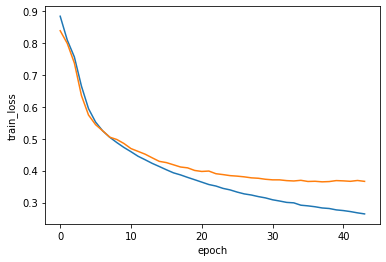

In [ ]:
visualizer(train_losses,valid_losses)

In [ ]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [ ]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [ ]:
embedding_dim=300
hidden_dim=512
num_vocabs=len(tokens)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.2
model=BiLSTMClassificier(embedding_dim=embedding_dim,hidden_dim=hidden_dim,num_vocabs=num_vocabs,num_pos_tags=num_pos_tags,drop_rate=drop_rate)#,embedding_weights=weights)

In [ ]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

In [ ]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/bilstm/ckpt-35


In [ ]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:
  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i['tokens'] for i in inputs],dtype=tf.int32)

  pos_tag_ids=tf.constant([i['pos_tags'] for i in inputs],dtype=tf.int32)
  
  
  logits=model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

In [ ]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.89668   0.95502   0.92493      2290
           1    0.71790   0.69406   0.70578       572
           2    0.86395   0.87586   0.86986       145
           3    0.77778   0.13208   0.22581       159

    accuracy                        0.86292      3166
   macro avg    0.81408   0.66425   0.68159      3166
weighted avg    0.85691   0.86292   0.84770      3166

